In [1]:
%load_ext autoreload
%autoreload 2
%reset -f
from custom_imports import *

/home/bzr0014/anaconda3/envs/tensorGpu2/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:458: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/bzr0014/anaconda3/envs/tensorGpu2/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:459: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/bzr0014/anaconda3/envs/tensorGpu2/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:460: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/bzr0014/anaconda3/envs/te

In [2]:
client = Client(scheduler_file="/home/bzr0014/schedfile")

In [3]:
client.restart()

Client Scheduler: tcp://131.204.27.88:8786 Dashboard: http://131.204.27.88:8787/status,Cluster Workers: 50 Cores: 100 Memory: 1000.00 GB


In [4]:
DATAROOT = "data"

In [5]:
multi_class_images = joblib.load(f"{DATAROOT}/multi_label_images.dict")
image_names = joblib.load(f"{DATAROOT}/image_names.pkl")

In [6]:
raw_images = {k: v for k, v in dict(zip(image_names, joblib.load(f"{DATAROOT}/raw_images.pkl"))).items() if k in multi_class_images}

In [7]:
original_images = {k: v for k, v in dict(zip(image_names, joblib.load(f"{DATAROOT}/images.pkl"))).items() if k in multi_class_images}

In [8]:
assert len(raw_images) == len(original_images)
assert len(raw_images) == len(multi_class_images)

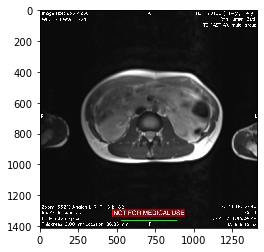

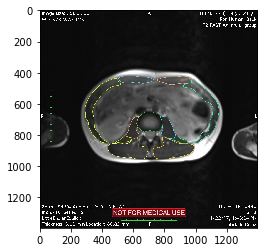

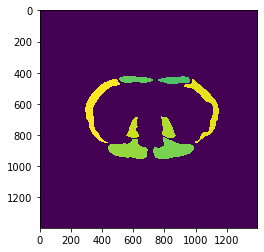

In [9]:
label = np.random.choice(list(multi_class_images.keys()))
plt.imshow(raw_images[label])
plt.show()
plt.imshow(original_images[label])
plt.show()
plt.imshow(multi_class_images[label])

In [10]:
TRAIN_SIZE = 400

In [11]:
from sklearn.model_selection import train_test_split
imgTrLabels, imgTsLabels, maskedTrLabels, maskedTsLabels = \
    train_test_split(list(raw_images.keys()), list(multi_class_images.keys()), random_state=17, test_size=.6)
imgTr = {k: raw_images[k] for k in imgTrLabels}
imgTs = {k: raw_images[k] for k in imgTsLabels}
maskedTr = {k: multi_class_images[k] for k in maskedTrLabels}
maskedTs = {k: multi_class_images[k] for k in maskedTsLabels}
assert len(imgTr) == len(maskedTr)
assert len(imgTs) == len(maskedTs)

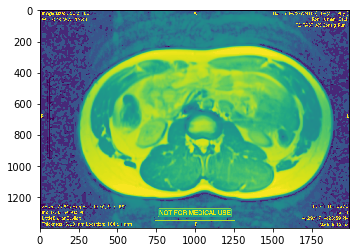

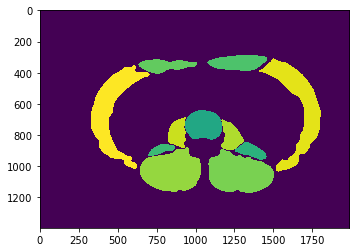

In [12]:
label = np.random.choice(list(maskedTr.keys()))
plt.imshow(cv2.equalizeHist(imgTr[label].mean(axis=2).astype('uint8')))
plt.show()
plt.imshow(maskedTr[label])

In [119]:
def clean_image(img, shape):
    if len(img.shape) > 2:
        img = img.mean(axis=2).astype('uint8')
    cleaned_hist_img = cv2.equalizeHist(img)
    gaussian_kernel_size = tuple(((x//40)//2)*2+1 for x in cleaned_hist_img.shape)
    cv2.GaussianBlur(cleaned_hist_img, gaussian_kernel_size, 1)
    zoom_rate = tuple(x/y for x,y in zip(shape, img.shape)) if isinstance(shape, tuple) \
                else shape if shape < 1 else shape/img.shape[0]
    out = zoom(img, zoom_rate)
    return out

def clean_mask(img, shape):
    if len(img.shape) > 2:
        img = img.sum(axis=2).astype('uint8')
    zoom_rate = tuple(x/y for x,y in zip(shape, img.shape)) if isinstance(shape, tuple) \
                else shape if shape < 1 else shape/img.shape[0]
    out = []
    for c in sorted(np.unique(img))[1:]:
        segment = (zoom((img==c)*255, zoom_rate)>0)*c
        out.append(segment)
    return np.max(np.array(out), axis=0)

#def get_image_positional_values(img):
#    w, h, *_ = img.shape
#    x, y = np.meshgrid(np.arange(w)/w, np.arange(h)/h)
#    return np.vstack([x.reshape(-1), y.reshape(-1)]).T, img.reshape(-1)



mri_analysis/4.Contiguous Set#2/Control/Control - Post/Female/Subject F4B/3-COF4B-15:50RepBeh.jpg


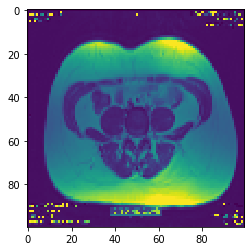

[  0 150 180 190 200 210 220 230 240 250]


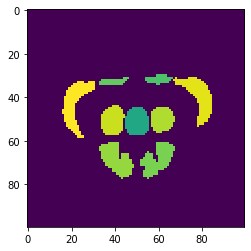

In [125]:
label = np.random.choice(list(maskedTr.keys()))
#label = "mri_analysis/4.Contiguous Set#2/Weight Lifting/Weight Lifting - Post/Female/Subject WF5B/1-WF5B-4:50RepBeh.jpg"
#label = 'mri_analysis/4.Contiguous Set#2/Control/Control - Pre/Female/Subject F4/3-COF4-15:50Rep-Beh.jpg'
print(label)
plt.imshow(clean_image(imgTr[label], (100, 100)))
plt.show()
tmp = clean_mask(maskedTr[label], (100, 100))
plt.imshow(tmp)
print(np.unique(tmp))

In [384]:
cleaned_images_del = [delayed(clean_image)(x, (100, 100)) for x in imgTr.values()]
cleaned_masks = [delayed(clean_mask)(x, (100, 100)) for x in maskedTr.values()]

In [385]:
from keras.preprocessing.image import ImageDataGenerator

In [386]:
cleaned_images_arr = np.array(compute(cleaned_images_del)[0])
cleaned_images = cleaned_images_arr.reshape(*cleaned_images_arr.shape, 1)

cleaned_masks = np.array(compute(cleaned_masks)[0])
cleaned_masks = cleaned_masks.reshape(*cleaned_masks.shape, 1)
encoder = OneHotEncoder()
cleaned_masks_encoded = \
    encoder.fit_transform(cleaned_masks.reshape(-1, 1)).toarray().reshape(*cleaned_masks.shape[:-1], -1)

In [379]:
cleaned_images.shape, cleaned_masks_encoded.shape

((310, 100, 100, 1), (310, 100, 100, 12))

In [367]:
aug = ImageDataGenerator(rotation_range=20, zoom_range=0.15,
	width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15, 
	horizontal_flip=True, fill_mode="nearest")

In [368]:
# Keras simple deep model:
def build_v02(width, height, depth, init="he_normal"):
    # initialize the model along with the input shape to be
    # "channels last" and the channels dimension itself
    model = Sequential()
    inputShape = (height, width, depth)
    chanDim = -1

    # if we are using "channels first", update the input shape
    # and channels dimension
    if K.image_data_format() == "channels_first":
        inputShape = (depth, height, width)
        chanDim = 1
        
    # our first CONV layer will learn a total of 16 filters, each
    # Of which are 7x7 -- we'll then apply 2x2 strides to reduce
    # the spatial dimensions of the volume
    #model.add(Conv2D(32, (10, 10), strides=(1, 1), padding="same",
    #    kernel_initializer=init,# kernel_regularizer=reg,
    #    input_shape=inputShape))

    # here we stack two CONV layers on top of each other where
    # each layerswill learn a total of 32 (3x3) filters
    model.add(Conv2D(32, (10, 10), padding="same",
        kernel_initializer=init, #kernel_regularizer=reg)
                    ))
    model.add(Activation("relu"))
    #model.add(BatchNormalization(axis=chanDim))
    model.add(Conv2D(32, (5, 5), strides=(1, 1), padding="same",
        kernel_initializer=init, #kernel_regularizer=reg)
                    ))
    model.add(Activation("relu"))
    #model.add(BatchNormalization(axis=chanDim))
    model.add(Dropout(0.25))
    ##model.add(BatchNormalization(axis=chanDim))
    model.add(Conv2D(16, (3, 3), strides=(1, 1), padding="same",
        kernel_initializer=init,  #kernel_regularizer=reg
                    )
             )
    model.add(Activation("relu"))
    model.add(Conv2D(1, (3, 3), strides=(1, 1), padding="same",
        kernel_initializer=init, #kernel_regularizer=reg)
                    ))
    model.add(Activation("relu"))
    #model.add(Activation("sigmoid"))
    #model.add(BatchNormalization(axis=chanDim))
    return model

In [369]:
model = build_v02(100, 100, depth=1)
opt = Adam(lr=1e-4)#, decay=1e-4 / epochs)
model.compile(loss=losses.mse, optimizer=opt, metrics=["accuracy"])

In [370]:
xy = np.concatenate([cleaned_images, cleaned_masks, cleaned_masks], axis=3)
xy.shape

(310, 100, 100, 3)

In [375]:
def mardas(aug):
    for xy in aug:
        yield xy[:, :, :, 0:1], xy[:, :, :, 1:2]
generator = mardas(aug.flow(xy, batch_size=BS))

In [377]:
BS = 64
EPOCHS = 1000
#model.fit(cleaned_images, cleaned_masks, epochs=1)
model.fit_generator(generator,
	steps_per_epoch=len(cleaned_images) // BS, epochs=EPOCHS)

Epoch 1/1000
4/4 [==============================] - 1s 252ms/step - loss: 2423.1777 - acc: 0.5322
Epoch 2/1000
4/4 [==============================] - 1s 234ms/step - loss: 2456.1040 - acc: 0.5733
Epoch 3/1000
4/4 [==============================] - 1s 219ms/step - loss: 2315.2961 - acc: 0.5430
Epoch 4/1000
4/4 [==============================] - 1s 221ms/step - loss: 2395.0502 - acc: 0.5684
Epoch 5/1000
4/4 [==============================] - 1s 222ms/step - loss: 2350.9022 - acc: 0.5504
Epoch 6/1000
4/4 [==============================] - 1s 211ms/step - loss: 2354.9086 - acc: 0.5634
Epoch 7/1000
4/4 [==============================] - 1s 233ms/step - loss: 2358.9851 - acc: 0.5529
Epoch 8/1000
4/4 [==============================] - 1s 219ms/step - loss: 2331.6820 - acc: 0.5515
Epoch 9/1000
4/4 [==============================] - 1s 216ms/step - loss: 2378.4428 - acc: 0.5499
Epoch 10/1000
4/4 [==============================] - 1s 218ms/step - loss: 2316.6883 - acc: 0.5624
Epoch 11/1000
4/4 [

KeyboardInterrupt: 

# Result: Failed

In [ ]:
cleaned_images_del = [delayed(clean_image)(x, 200) for x in imgTr.values()]
cleaned_masks = [delayed(clean_mask)(x, 200) for x in maskedTr.values()]